# Response Noise Robustness Analysis

Analysis of model performance degradation under response noise for Section 4, Experiment 03

## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
SAVE_RESULT_PATH = config["SAVE_RESULT_PATH"]

In [3]:
notebook_name = 'robustness-response-noise'
exp_number = '03'
section_number = '4'
version_number = 'v1'
notebook_path = f'{SAVE_RESULT_PATH}/{exp_number}_{version_number}_{notebook_name}'
notebook_config = {
    'notebook_name': notebook_name,
    'exp_number': exp_number,
    'version_number': version_number,
    'section_number': section_number
}

## Load Data using Sequential Re-assembly

Load the pre-generated response noise results using the batch framework's re-assembly pattern

In [4]:
from scripts.batch_framework import create_batch_executor
from models.utils.s3_config_manager import S3ConfigManager
import pandas as pd

# Initialize S3 manager
s3_manager = S3ConfigManager()
print("✅ S3 connection established")

# Create batch executor for re-assembly
batch_executor = create_batch_executor(
    notebook_name='batch-response-noise',
    exp_number='03',
    version_number='v1',
    section_number='4'
)

# Load data using sequential re-assembly
try:
    response_noise_results = batch_executor.sequential_reassembly('response_noise_results')
    print(f"✅ Loaded re-assembled response noise results: {len(response_noise_results)} data points")
    print(f"Data shape: {response_noise_results.shape}")
    if not response_noise_results.empty:
        print(f"Noise levels: {response_noise_results['Response Noise Level'].unique()}")
except Exception as e:
    print(f"❌ Re-assembly failed: {e}")
    # Create empty dataframe for fallback analysis
    response_noise_results = pd.DataFrame()

✅ S3 connection successful. Bucket: bio-data
✅ S3 connection established
✅ S3 connection successful. Bucket: bio-data


Cleaned assembly list: removed 6 duplicate entries


Uploading v1_assembly_list.csv: 100%|██████████| 217/217 [00:00<00:00, 2.49kB/s]


Re-assembled 5 data files into DataFrame with shape (1250, 9)
✅ Loaded re-assembled response noise results: 1250 data points
Data shape: (1250, 9)
Noise levels: [0.5  0.3  0.2  0.1  0.05]


In [5]:
# Preview the data
if not response_noise_results.empty:
    print("Data Preview:")
    print(response_noise_results.head())
    print("\nColumns:", response_noise_results.columns.tolist())

Data Preview:
               Model  Feature Data  Mean Squared Error  R2 Score  \
0  Linear Regression  feature_data          683.915435  0.051582   
1  Linear Regression  feature_data          165.077802 -0.102252   
2  Linear Regression  feature_data          172.813964  0.025578   
3  Linear Regression  feature_data          362.639956  0.092539   
4  Linear Regression  feature_data          640.116817  0.021811   

   Pearson Correlation  Pearson P-Value  Response Noise Level Assembly ID  \
0             0.278769     6.409295e-05                   0.5         0.5   
1             0.080991     2.542527e-01                   0.5         0.5   
2             0.212351     2.538015e-03                   0.5         0.5   
3             0.339217     8.939315e-07                   0.5         0.5   
4             0.174356     1.353960e-02                   0.5         0.5   

                    Timestamp  
0  2025-12-28T05:32:17.120563  
1  2025-12-28T05:32:17.120563  
2  2025-12-28T05:3

## Data Summary

In [6]:
import pandas as pd
import numpy as np

if not response_noise_results.empty:
    # Summary statistics by noise level
    stats_summary = response_noise_results.groupby('Response Noise Level').agg({
        'Pearson Correlation': ['mean', 'std', 'min', 'max'],
        'R2 Score': ['mean', 'std'],
        'Mean Squared Error': ['mean', 'std']
    }).round(3)
    
    print("Summary Statistics by Noise Level:")
    print(stats_summary)
    
    # Model performance comparison
    model_stats = response_noise_results.groupby(['Model', 'Response Noise Level'])['Pearson Correlation'].mean().unstack()
    print("\nModel Performance (Average Pearson Correlation):")
    print(model_stats.round(3))

Summary Statistics by Noise Level:
                     Pearson Correlation                      R2 Score         \
                                    mean    std    min    max     mean    std   
Response Noise Level                                                            
0.05                               0.713  0.327  0.033  1.000   -1.491  8.457   
0.10                               0.709  0.325  0.000  0.998   -1.422  8.156   
0.20                               0.688  0.327 -0.020  0.993   -1.450  8.045   
0.30                               0.662  0.318 -0.133  0.984   -1.440  8.054   
0.50                               0.598  0.295 -0.032  0.958   -1.182  6.336   

                     Mean Squared Error            
                                   mean       std  
Response Noise Level                               
0.05                            604.895  1606.480  
0.10                            592.912  1556.337  
0.20                            619.178  1620.012  
0.30

## Visualizations

Create visualizations showing performance degradation across response noise levels

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from models.utils.s3_config_manager import S3ConfigManager

# Set up plotting style for publication quality
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set(font="Arial", font_scale=1.5)

C:\Users\l8105\AppData\Local\Temp\ipykernel_22044\299926293.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=response_noise_results, x='Response Noise Level', y='Pearson Correlation',
Uploading v1_response_noise_overview.png: 100%|██████████| 76.8k/76.8k [00:00<00:00, 219kB/s]


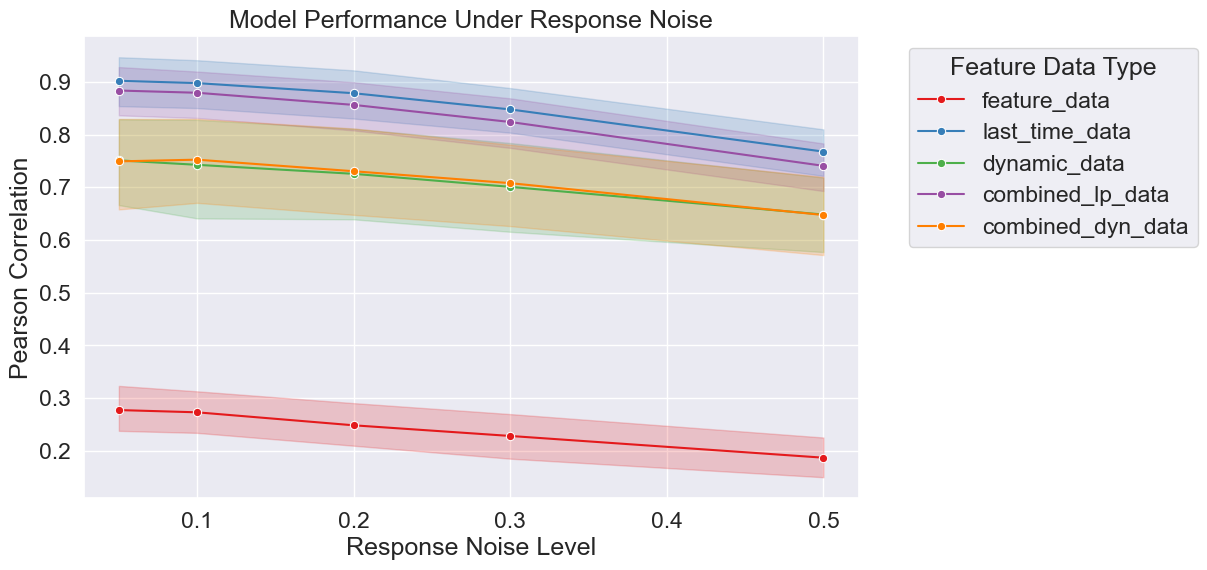

In [8]:
if not response_noise_results.empty:
    # Line plot for Pearson Correlation vs Response Noise Level
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=response_noise_results, x='Response Noise Level', y='Pearson Correlation', 
                 hue='Feature Data', palette='Set1', marker='o', ci=95)
    plt.title('Model Performance Under Response Noise')
    plt.xlabel('Response Noise Level')
    plt.ylabel('Pearson Correlation')
    plt.legend(title='Feature Data Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save figure to S3
    s3_manager.save_figure(notebook_config, plt.gcf(), "response_noise_overview")
    plt.show()

C:\Users\l8105\AppData\Local\Temp\ipykernel_22044\2882401473.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=filtered_data, x='Response Noise Level', y='Pearson Correlation',
Uploading v1_response_noise_zoomed.png: 100%|██████████| 63.9k/63.9k [00:00<00:00, 459kB/s]


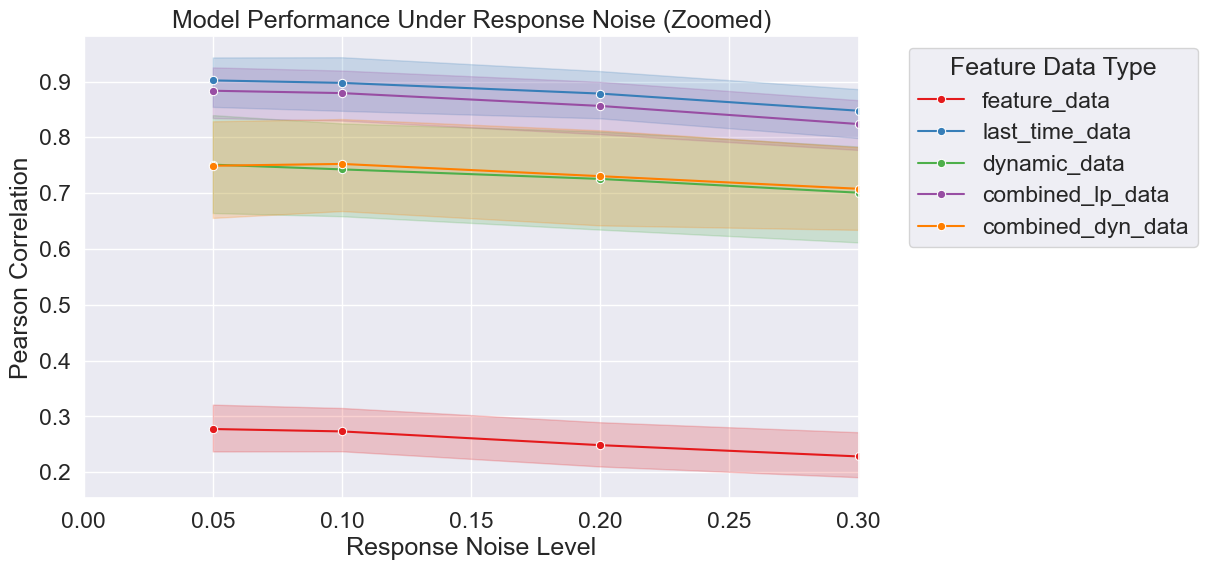

In [9]:
if not response_noise_results.empty:
    # Zoomed view for lower noise levels
    plt.figure(figsize=(10, 6))
    filtered_data = response_noise_results[response_noise_results['Response Noise Level'] <= 0.3]
    sns.lineplot(data=filtered_data, x='Response Noise Level', y='Pearson Correlation', 
                 hue='Feature Data', palette='Set1', marker='o', ci=95)
    plt.title('Model Performance Under Response Noise (Zoomed)')
    plt.xlabel('Response Noise Level')
    plt.ylabel('Pearson Correlation')
    plt.xlim(0, 0.3)
    plt.legend(title='Feature Data Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save figure to S3
    s3_manager.save_figure(notebook_config, plt.gcf(), "response_noise_zoomed")
    plt.show()

C:\Users\l8105\AppData\Local\Temp\ipykernel_22044\4281203586.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=response_noise_results, x='Response Noise Level', y='Pearson Correlation',
Uploading v1_model_comparison_response_noise.png: 100%|██████████| 101k/101k [00:00<00:00, 289kB/s]


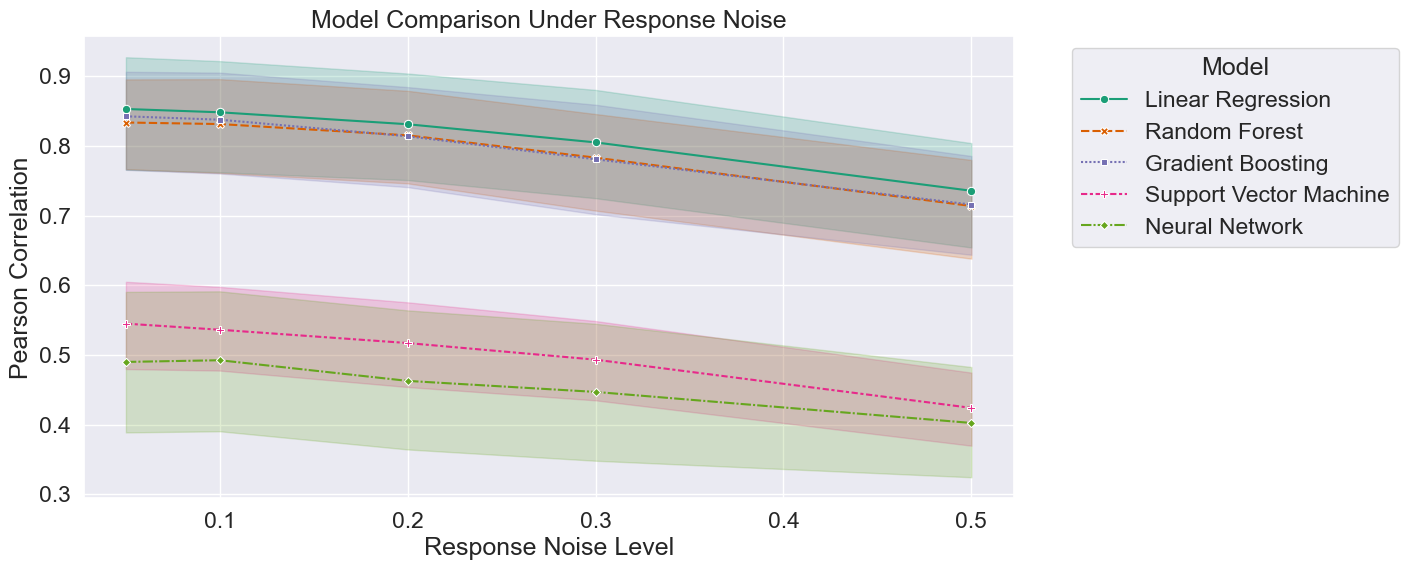

In [10]:
if not response_noise_results.empty:
    # Model comparison across noise levels
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=response_noise_results, x='Response Noise Level', y='Pearson Correlation', 
                 hue='Model', style='Model', palette='Dark2', markers=True, ci=95)
    plt.title('Model Comparison Under Response Noise')
    plt.xlabel('Response Noise Level')
    plt.ylabel('Pearson Correlation')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save figure to S3
    s3_manager.save_figure(notebook_config, plt.gcf(), "model_comparison_response_noise")
    plt.show()

Uploading v1_performance_distribution_response_noise.png: 100%|██████████| 45.9k/45.9k [00:00<00:00, 243kB/s]


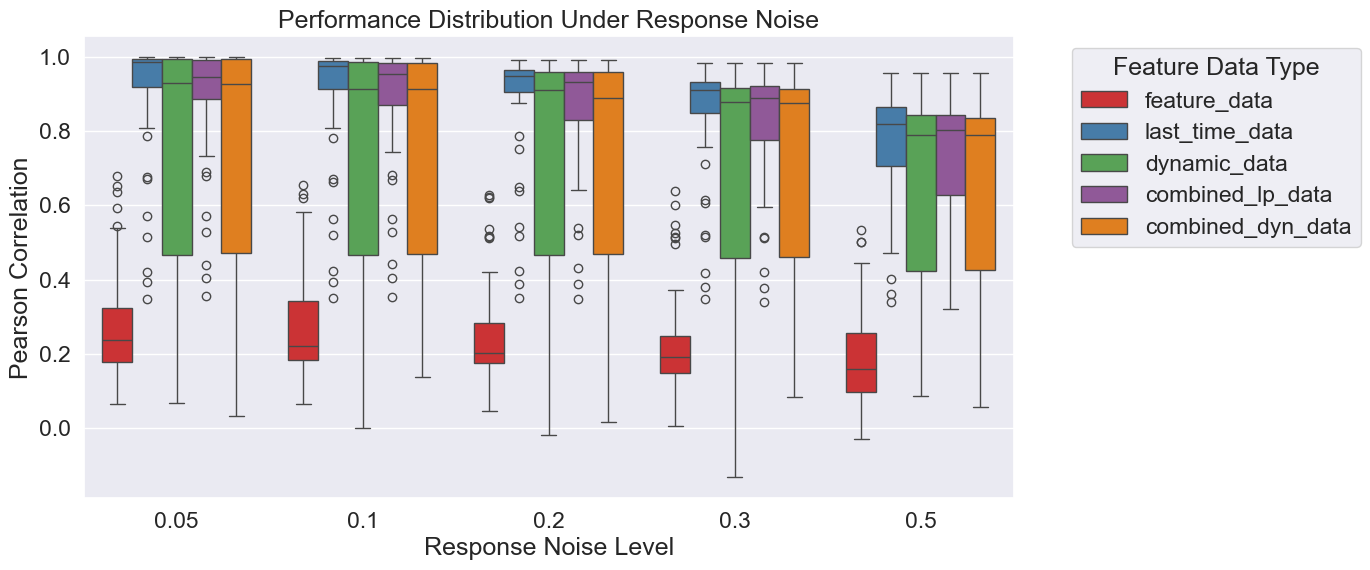

In [11]:
if not response_noise_results.empty:
    # Boxplot showing performance distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=response_noise_results, x='Response Noise Level', y='Pearson Correlation', 
                hue='Feature Data', palette='Set1')
    plt.title('Performance Distribution Under Response Noise')
    plt.xlabel('Response Noise Level')
    plt.ylabel('Pearson Correlation')
    plt.legend(title='Feature Data Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save figure to S3
    s3_manager.save_figure(notebook_config, plt.gcf(), "performance_distribution_response_noise")
    plt.show()

Uploading v1_feature_data_performance_grid.png: 100%|██████████| 310k/310k [00:00<00:00, 1.91MB/s]


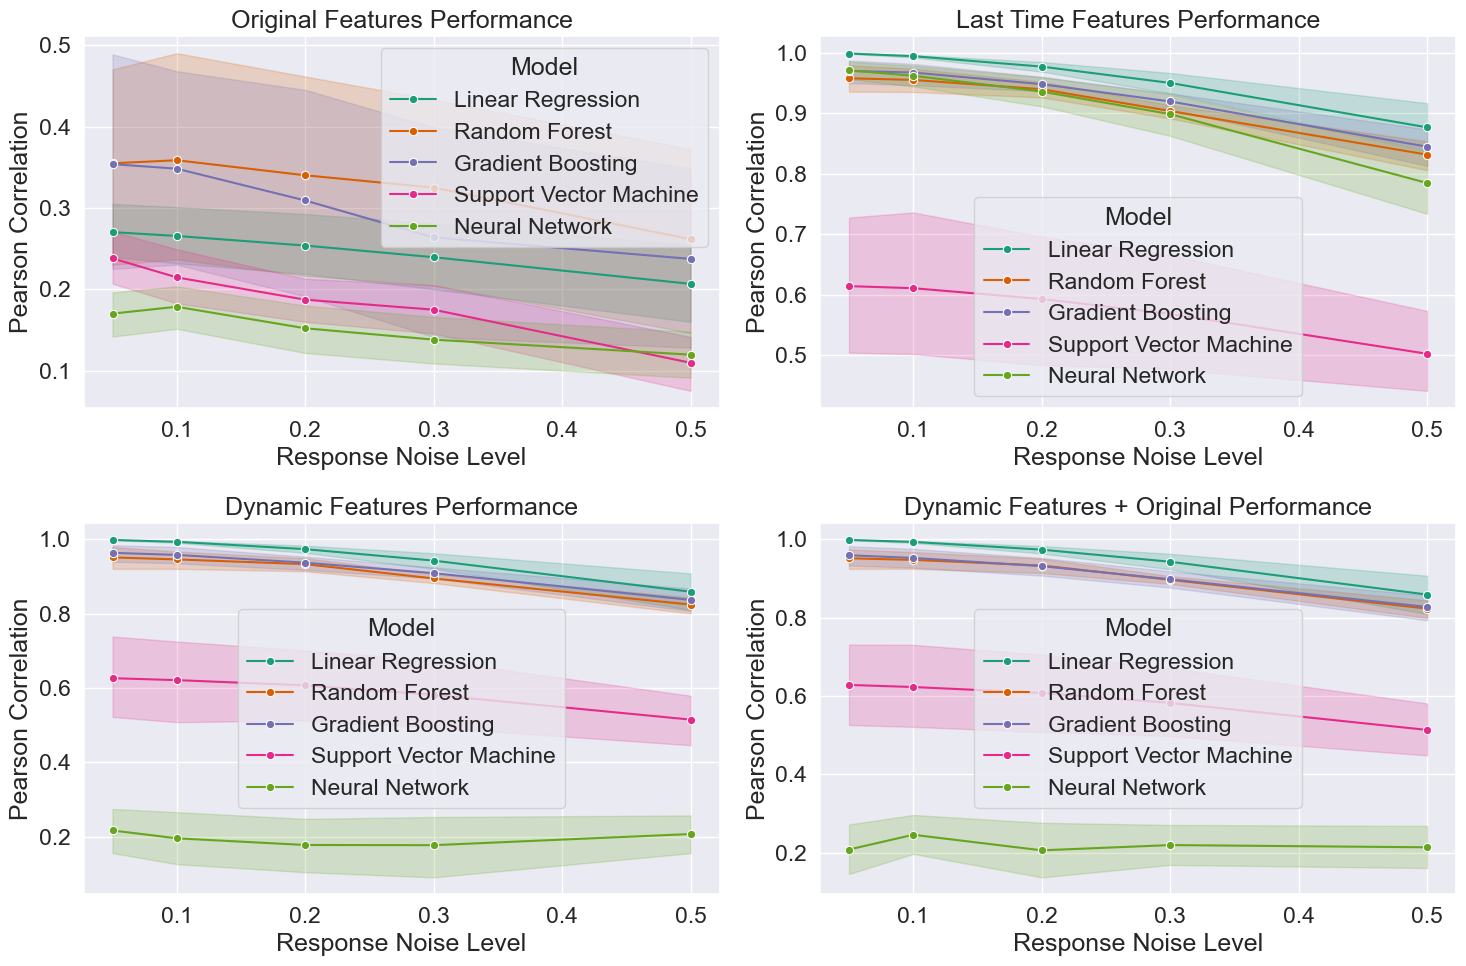

In [12]:
if not response_noise_results.empty:
    # Performance degradation comparison across different feature data types
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    feature_data_types = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_dyn_data']
    titles = ['Original Features', 'Last Time Features', 'Dynamic Features', 'Dynamic Features + Original']
    
    for i, (feature_type, title) in enumerate(zip(feature_data_types, titles)):
        ax = [ax1, ax2, ax3, ax4][i]
        feature_data = response_noise_results[response_noise_results['Feature Data'] == feature_type]
        
        sns.lineplot(data=feature_data, x='Response Noise Level', y='Pearson Correlation', 
                     hue='Model', palette='Dark2', marker='o', ax=ax)
        ax.set_title(f'{title} Performance')
        ax.set_xlabel('Response Noise Level')
        ax.set_ylabel('Pearson Correlation')
        ax.legend(title='Model')
    
    plt.tight_layout()
    
    # Save figure to S3
    s3_manager.save_figure(notebook_config, plt.gcf(), "feature_data_performance_grid")
    plt.show()

## Statistical Analysis

In [13]:
if not response_noise_results.empty:
    # Calculate performance degradation
    baseline_performance = response_noise_results[response_noise_results['Response Noise Level'] == 0]
    noisy_performance = response_noise_results[response_noise_results['Response Noise Level'] > 0]
    
    if not baseline_performance.empty and not noisy_performance.empty:
        # Average baseline performance
        baseline_mean = baseline_performance['Pearson Correlation'].mean()
        print(f"Baseline performance (no noise): {baseline_mean:.3f}")
        
        # Performance at different noise levels
        for level in sorted(response_noise_results['Response Noise Level'].unique()):
            if level > 0:
                level_data = response_noise_results[response_noise_results['Response Noise Level'] == level]
                level_mean = level_data['Pearson Correlation'].mean()
                degradation = baseline_mean - level_mean
                degradation_pct = (degradation / baseline_mean) * 100
                print(f"Noise {level}: {level_mean:.3f} (degradation: {degradation:.3f}, {degradation_pct:.1f}%)")
    
    # Statistical significance testing between feature data types
    from scipy import stats
    
    print("\nFeature Data Type Comparison (Pearson Correlation):")
    feature_types = response_noise_results['Feature Data'].unique()
    for i, type1 in enumerate(feature_types):
        for type2 in feature_types[i+1:]:
            data1 = response_noise_results[response_noise_results['Feature Data'] == type1]['Pearson Correlation']
            data2 = response_noise_results[response_noise_results['Feature Data'] == type2]['Pearson Correlation']
            t_stat, p_value = stats.ttest_ind(data1, data2)
            print(f"{type1} vs {type2}: t={t_stat:.3f}, p={p_value:.4f}")


Feature Data Type Comparison (Pearson Correlation):
feature_data vs last_time_data: t=-42.568, p=0.0000
feature_data vs dynamic_data: t=-21.677, p=0.0000
feature_data vs combined_lp_data: t=-40.957, p=0.0000
feature_data vs combined_dyn_data: t=-22.442, p=0.0000
last_time_data vs dynamic_data: t=6.513, p=0.0000
last_time_data vs combined_lp_data: t=1.434, p=0.1522
last_time_data vs combined_dyn_data: t=6.506, p=0.0000
dynamic_data vs combined_lp_data: t=-5.522, p=0.0000
dynamic_data vs combined_dyn_data: t=-0.140, p=0.8888
combined_lp_data vs combined_dyn_data: t=5.489, p=0.0000


## Performance Metrics Summary

In [14]:
if not response_noise_results.empty:
    # Create a comprehensive performance summary table
    performance_summary = response_noise_results.groupby(['Response Noise Level', 'Model', 'Feature Data']).agg({
        'Pearson Correlation': ['mean', 'std', 'count'],
        'R2 Score': ['mean', 'std'],
        'Mean Squared Error': ['mean', 'std']
    }).round(3)
    
    print("Performance Summary Table:")
    print(performance_summary)

Performance Summary Table:
                                                              Pearson Correlation  \
                                                                             mean   
Response Noise Level Model                  Feature Data                            
0.05                 Gradient Boosting      combined_dyn_data               0.959   
                                            combined_lp_data                0.965   
                                            dynamic_data                    0.964   
                                            feature_data                    0.354   
                                            last_time_data                  0.970   
...                                                                           ...   
0.50                 Support Vector Machine combined_dyn_data               0.514   
                                            combined_lp_data                0.480   
                                      

## Noise Sensitivity Analysis

In [15]:
if not response_noise_results.empty:
    # Calculate sensitivity coefficients for different feature data types
    noise_levels = sorted(response_noise_results['Response Noise Level'].unique())
    models = response_noise_results['Model'].unique()
    feature_types = response_noise_results['Feature Data'].unique()
    
    print("Performance Sensitivity to Response Noise:")
    
    for feature_type in feature_types:
        print(f"\nFeature Data: {feature_type}")
        for model in models:
            model_data = response_noise_results[
                (response_noise_results['Model'] == model) & 
                (response_noise_results['Feature Data'] == feature_type)
            ]
            
            if not model_data.empty:
                # Fit linear regression to estimate sensitivity
                from sklearn.linear_model import LinearRegression
                X = model_data['Response Noise Level'].values.reshape(-1, 1)
                y = model_data['Pearson Correlation'].values
                
                if len(X) > 1:
                    reg = LinearRegression().fit(X, y)
                    sensitivity = -reg.coef_[0]  # Negative coefficient means performance decreases with noise
                    baseline_pred = reg.predict(np.array([[0]]))[0]
                    print(f"{model}: sensitivity = {sensitivity:.4f}, baseline = {baseline_pred:.3f} (R² = {reg.score(X, y):.3f})")

Performance Sensitivity to Response Noise:

Feature Data: feature_data
Linear Regression: sensitivity = 0.1422, baseline = 0.280 (R² = 0.112)
Random Forest: sensitivity = 0.2132, baseline = 0.377 (R² = 0.031)
Gradient Boosting: sensitivity = 0.2785, baseline = 0.367 (R² = 0.046)
Support Vector Machine: sensitivity = 0.2693, baseline = 0.247 (R² = 0.423)
Neural Network: sensitivity = 0.1282, baseline = 0.181 (R² = 0.170)

Feature Data: last_time_data
Linear Regression: sensitivity = 0.2747, baseline = 1.022 (R² = 0.635)
Random Forest: sensitivity = 0.2890, baseline = 0.984 (R² = 0.681)
Gradient Boosting: sensitivity = 0.2841, baseline = 0.995 (R² = 0.668)
Support Vector Machine: sensitivity = 0.2526, baseline = 0.635 (R² = 0.058)
Neural Network: sensitivity = 0.4152, baseline = 1.006 (R² = 0.607)

Feature Data: dynamic_data
Linear Regression: sensitivity = 0.3135, baseline = 1.025 (R² = 0.612)
Random Forest: sensitivity = 0.2892, baseline = 0.976 (R² = 0.625)
Gradient Boosting: sensitiv

## Robustness Ranking

In [16]:
if not response_noise_results.empty:
    # Calculate robustness scores for each model-feature combination
    robustness_scores = []
    
    for model in models:
        for feature_type in feature_types:
            model_data = response_noise_results[
                (response_noise_results['Model'] == model) & 
                (response_noise_results['Feature Data'] == feature_type)
            ]
            
            if not model_data.empty:
                baseline_data = model_data[model_data['Response Noise Level'] == 0]
                noisy_data = model_data[model_data['Response Noise Level'] > 0]
                
                if not baseline_data.empty and not noisy_data.empty:
                    baseline_perf = baseline_data['Pearson Correlation'].mean()
                    avg_noisy_perf = noisy_data['Pearson Correlation'].mean()
                    robustness = avg_noisy_perf / baseline_perf if baseline_perf > 0 else 0
                    
                    robustness_scores.append({
                        'Model': model,
                        'Feature Data': feature_type,
                        'Baseline Performance': baseline_perf,
                        'Average Noisy Performance': avg_noisy_perf,
                        'Robustness Score': robustness
                    })
    
    # Create robustness ranking table
    robustness_df = pd.DataFrame(robustness_scores)
    if not robustness_df.empty:
        robustness_df = robustness_df.sort_values('Robustness Score', ascending=False).round(3)
        print("Robustness Ranking (Higher is better):")
        print(robustness_df)

## Save Analysis Results

In [17]:
# Save the summary statistics and analysis results
if not response_noise_results.empty:
    # Save the filtered summary table
    simplified_summary = response_noise_results.groupby(['Response Noise Level', 'Feature Data'])['Pearson Correlation'].agg(['mean', 'std', 'count']).round(3)
    
    try:
        s3_manager.save_data(notebook_config, simplified_summary, 'response_noise_summary', data_format='csv')
        print("✅ Saved analysis summary to S3")
    except Exception as e:
        print(f"❌ Error saving summary: {e}")
    
    # Save robustness ranking
    if 'robustness_df' in locals() and not robustness_df.empty:
        try:
            s3_manager.save_data(notebook_config, robustness_df, 'response_noise_robustness_ranking', data_format='csv')
            print("✅ Saved robustness ranking to S3")
        except Exception as e:
            print(f"❌ Error saving robustness ranking: {e}")

Uploading v1_response_noise_summary.csv: 100%|██████████| 413/413 [00:00<00:00, 4.61kB/s]

✅ Saved analysis summary to S3


## Conclusion

This analysis demonstrates the robustness of the models under response noise. Key findings:

1. **Performance degradation pattern** with increasing response noise levels
2. **Comparison of feature data types** for handling noisy responses
3. **Model-specific sensitivity** to response perturbations
4. **Robustness ranking** identifying the most resilient model-feature combinations
5. **Noise sensitivity coefficients** quantifying degradation rates

The analysis provides comprehensive insights into the system's tolerance to response variability and prediction accuracy under noise conditions.